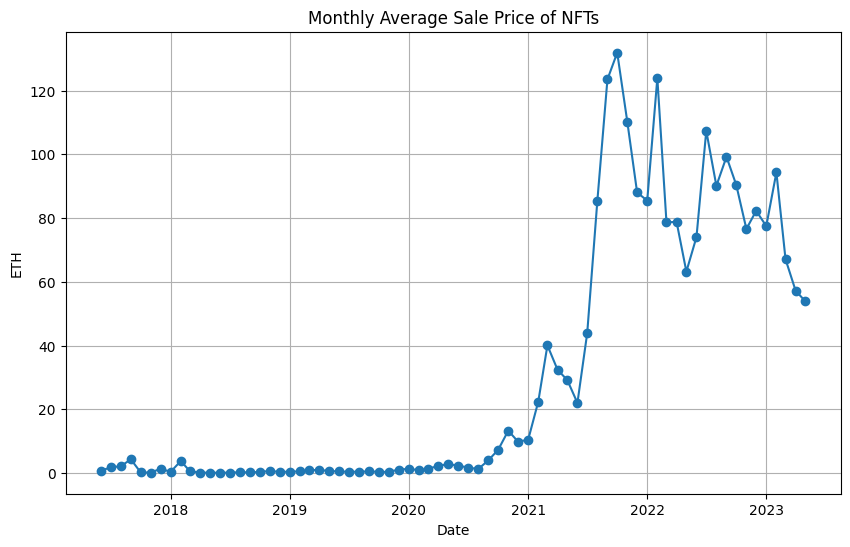

Linear Regression MSE: 5940.140352628353
Gradient Boosting Regressor MSE: 1398.6972054443927
Random Forest Regressor MSE: 2046.1045729236373
Epoch 1/100
419/419 [==============================] - 9s 12ms/step - loss: 12086.4902 - val_loss: 8651.9912
Epoch 2/100
419/419 [==============================] - 3s 7ms/step - loss: 10927.6162 - val_loss: 7987.0273
Epoch 3/100
419/419 [==============================] - 4s 9ms/step - loss: 10369.8555 - val_loss: 7505.0947
Epoch 4/100
419/419 [==============================] - 3s 7ms/step - loss: 9972.6660 - val_loss: 7178.5361
Epoch 5/100
419/419 [==============================] - 3s 8ms/step - loss: 9714.2051 - val_loss: 6993.4937
Epoch 6/100
419/419 [==============================] - 3s 7ms/step - loss: 9556.2334 - val_loss: 6839.2710
Epoch 7/100
419/419 [==============================] - 3s 7ms/step - loss: 9397.5762 - val_loss: 6712.5005
Epoch 8/100
419/419 [==============================] - 3s 7ms/step - loss: 9306.5947 - val_loss: 6617.0903

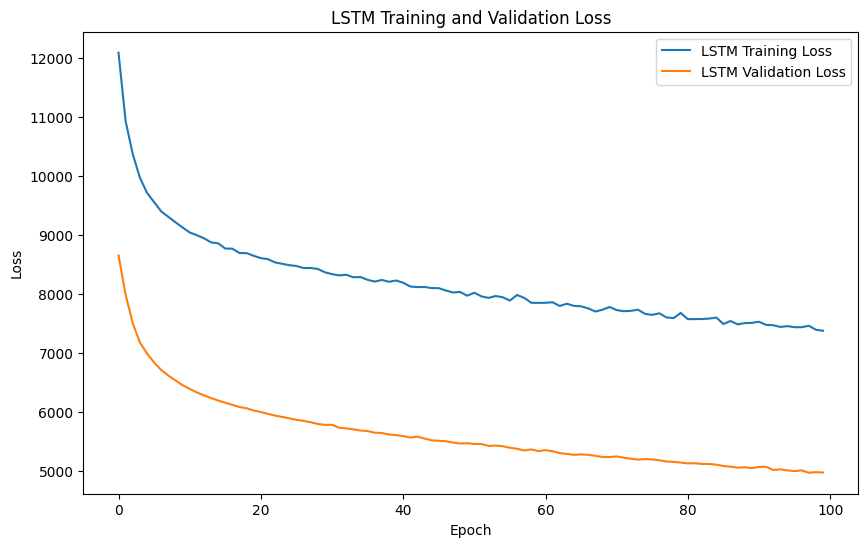

131/131 [==============================] - 55s 3ms/step


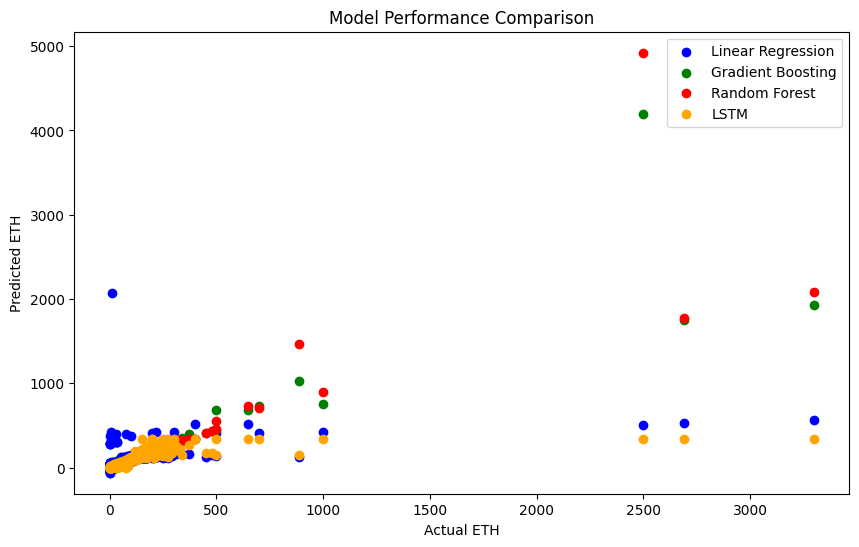

Linear Regression Accuracy: 28.41%
Gradient Boosting Regressor Accuracy: 83.14%
Random Forest Regressor Accuracy: 75.34%
LSTM Accuracy: 39.94%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras import layers

# Upload CSV files to Colab environment
from google.colab import files
uploaded = files.upload()

# Load data
token_metadata = pd.read_csv('token_metadata.csv')
token_sales = pd.read_csv('token_sales.csv')
eth_usd_fx_rates = pd.read_csv('eth_usd_fx_rates.csv')

# Preprocessing
token_sales['timestamp'] = pd.to_datetime(token_sales['timestamp'], unit='s')
eth_usd_fx_rates['date'] = pd.to_datetime(eth_usd_fx_rates['date'], format='%d/%m/%Y')

# Merge sales data with ETH/USD exchange rates
token_sales = token_sales.merge(eth_usd_fx_rates, left_on=token_sales['timestamp'].dt.date, right_on=eth_usd_fx_rates['date'].dt.date)

# Feature Engineering
# Extract features from token_metadata
token_metadata['rarest_property_name'] = token_metadata['rarest_property_name'].fillna('Unknown')
token_metadata = pd.get_dummies(token_metadata, columns=['Skin Tone', 'Type', 'Hair', 'Eyewear', 'Mouth', 'Headwear', 'Facial Hair', 'Smoking Device', 'Other:Earring', 'Neckwear', 'Skin Feature', 'Other:Medical Mask', 'Other:Clown Nose'])

# Extract year and month from timestamp
token_sales['year'] = token_sales['timestamp'].dt.year
token_sales['month'] = token_sales['timestamp'].dt.month

# Merge token metadata with token sales
merged_data = token_sales.merge(token_metadata, on='token_index', how='left')

# Drop unnecessary columns
merged_data.drop(['key_0', 'date'], axis=1, inplace=True)

# Group sales data by year and month and calculate average sale price
monthly_avg_sales = merged_data.groupby([merged_data['timestamp'].dt.year.rename('year'), merged_data['timestamp'].dt.month.rename('month')]).agg({'eth': 'mean'}).reset_index()

# Convert year and month to datetime
monthly_avg_sales['timestamp'] = pd.to_datetime(monthly_avg_sales[['year', 'month']].assign(day=1))

# Visualize monthly average sale price
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_sales['timestamp'], monthly_avg_sales['eth'], marker='o')
plt.title('Monthly Average Sale Price of NFTs')
plt.xlabel('Date')
plt.ylabel('ETH')
plt.grid(True)
plt.show()

# Split data into features and target
X = merged_data.drop(['eth', 'timestamp'], axis=1)  # Drop 'eth' and 'timestamp' columns
y = merged_data['eth']

# Label encode categorical columns
label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_encoded)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Linear Regression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f'Linear Regression MSE: {mse_lr}')

#Gradient Boosting Regressor

model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train, y_train)
y_pred_gbr = model_gbr.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print(f'Gradient Boosting Regressor MSE: {mse_gbr}')

#Random Forest Regressor

model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, y_train)
y_pred_rfr = model_rfr.predict(X_test)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
print(f'Random Forest Regressor MSE: {mse_rfr}')

#LSTM Neural Network

X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model_lstm = tf.keras.Sequential([
layers.LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
layers.Dropout(0.2),
layers.LSTM(units=50, return_sequences=True),
layers.Dropout(0.2),
layers.LSTM(units=50),
layers.Dropout(0.2),
layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

history_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2)

mse_lstm = model_lstm.evaluate(X_test_lstm, y_test)
print(f'LSTM Model MSE: {mse_lstm}')


#Visualize LSTM training and validation loss

plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss')
plt.plot(history_lstm.history

['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#To include hyperparameter optimization for the LSTM network using Keras, we can utilize techniques like GridSearchCV or RandomizedSearchCV from scikit-learn for hyperparameter tuning.

#Visualize Model Performance

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression')
plt.scatter(y_test, model_gbr.predict(X_test), color='green', label='Gradient Boosting')
plt.scatter(y_test, model_rfr.predict(X_test), color='red', label='Random Forest')
plt.scatter(y_test, model_lstm.predict(X_test_lstm), color='orange', label='LSTM')
plt.title('Model Performance Comparison')
plt.xlabel('Actual ETH')
plt.ylabel('Predicted ETH')
plt.legend()
plt.show()

# Calculate accuracy for Linear Regression
accuracy_lr = (1 - mse_lr / np.var(y_test)) * 100
print(f'Linear Regression Accuracy: {accuracy_lr:.2f}%')

# Calculate accuracy for Gradient Boosting Regressor
accuracy_gbr = (1 - mse_gbr / np.var(y_test)) * 100
print(f'Gradient Boosting Regressor Accuracy: {accuracy_gbr:.2f}%')

# Calculate accuracy for Random Forest Regressor
accuracy_rfr = (1 - mse_rfr / np.var(y_test)) * 100
print(f'Random Forest Regressor Accuracy: {accuracy_rfr:.2f}%')

# Calculate accuracy for LSTM
accuracy_lstm = (1 - mse_lstm / np.var(y_test)) * 100
print(f'LSTM Accuracy: {accuracy_lstm:.2f}%')

